In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
folder = 'results'
cases = os.listdir(folder)
cases

['1', '70_15_15', 'baseline', 'xvector']

In [3]:
case = cases[1]

path = os.path.join(os.getcwd(), folder, case)
with open(os.path.join(path, 'label_encoder.txt'), 'r') as file:
    emos = file.readlines()[:4]
d_emos = {int(emo[-2]): emo[1:4] for emo in emos}

df = pd.read_csv(path + '/predictions.csv')
df.prediction.replace(d_emos, inplace=True)
df.true_value.replace(d_emos, inplace=True)
df['correct'] = (df.prediction == df.true_value)
df.head()

,id,prediction,true_value,correct
0,psno2_neu_s342_orgn,sad,neu,False
1,psno2_hap_s412_orgn,hap,hap,True
2,psno4_neu_s825_orgn,ang,neu,False
3,psno5_sad_s636_orgn,sad,sad,True
4,psno2_neu_s462_orgn,sad,neu,False


In [4]:
table = pd.pivot_table(df, values='correct', index='prediction', columns='true_value',
                       aggfunc=len, fill_value=0, margins=True, margins_name='total')
table.to_csv(os.path.join(path, f'confusion_{case}.csv'))
print(table)

true_value  ang  hap  neu  sad  total
prediction                           
ang          82   14   11    4    111
hap          12   94   18    3    127
neu          11   47  108   29    195
sad           4   18   19   80    121
total       109  173  156  116    554


In [7]:
# see MINGKE XU1, FAN ZHANG2, SAMEE U.KHAN3, AND WEI ZHANG for definitions weighted/unweighted accuracy

table = pd.pivot_table(df, values='correct', index='prediction', columns='true_value',
                       aggfunc=len, fill_value=0)

# weighted accuracy:
weighted_acc = df.correct.mean().round(3)

# unweighted accuracy:
unweighted_acc = 0
for emo in ['ang', 'hap', 'neu', 'sad']:
    unweighted_acc += table.loc[emo, emo] / table.loc[:, emo].sum() / 4


print(f'ACCURACY: {weighted_acc} (weighted), {round(unweighted_acc, 3)} (unweighted)')

ACCURACY: 0.657 (weighted), 0.669 (unweighted)


In [6]:
table = pd.pivot_table(df, values='correct', index='prediction', columns='true_value',
                       aggfunc=len, fill_value=0)

results = pd.DataFrame()

# precision
for pred in ['ang', 'hap', 'neu', 'sad']:
    results.loc[pred, 'precision'] = (table.loc[pred, pred] / table.loc[pred, :].sum())

# recall
for emo in ['ang', 'hap', 'neu', 'sad']:
    results.loc[emo, 'recall'] = (table.loc[emo, emo] / table.loc[:, emo].sum())
    
results.to_csv(os.path.join(path, f'prec_rec_{case}.csv'))
print(results.round(3))

     precision  recall
ang      0.739   0.752
hap      0.740   0.543
neu      0.554   0.692
sad      0.661   0.690


could add a heatmap: https://devblogs.microsoft.com/cse/2015/11/29/data-preparation-the-balancing-act

In [7]:
epochs, lr, train_loss, valid_loss, valid_acc = [], [], [], [], []
with open(os.path.join(path, 'train_log.txt'), 'r') as file:
    lines = file.readlines()
    numbers = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", lines[-1])
    best_epoch, test_acc = int(numbers[0]), 1 - float(numbers[2])
    for line in lines[:-1]:
        numbers = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", line)
        epochs.append(int(numbers[0]))
        lr.append(float(numbers[1]))
        train_loss.append(float(numbers[2]))
        valid_loss.append(float(numbers[3]))
        valid_acc.append(1 - float(numbers[4]))

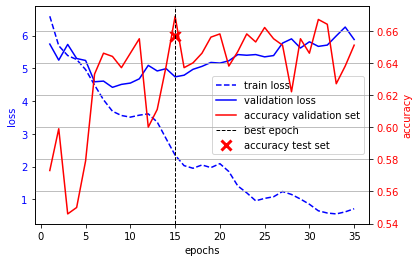

In [8]:
fig, ax1 = plt.subplots()

color='blue'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(epochs, train_loss, color=color, linestyle='--', label='train loss')
ax1.plot(epochs, valid_loss, color=color, label='validation loss')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color='red'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(epochs, valid_acc, color=color, label='accuracy validation set')
ax2.axvline(best_epoch, color='black', linestyle='--', linewidth=1, label='best epoch')
ax2.scatter(best_epoch, test_acc, color=color, marker= 'x', s=100, linewidths=3, label='accuracy test set')
ax2.tick_params(axis='y', labelcolor=color)


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax1.legend(lines, labels, loc=7)

plt.grid()
plt.savefig(os.path.join(path, f'fig_{case}.png'))
plt.show()